# Using DO and HPO xrefs to merge items

In [1]:
import pandas as pd
from pathlib import Path
from data_tools.wiki import get_curi_xrefs
from data_tools import df_processing as dfp
from data_tools import graphs as gt

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
nw_name = '10b_Diseae_Phenotype_Cleanup_preliminary_DOID_cleaning'
nw_dir = Path('../2_pipeline').resolve().joinpath(nw_name, 'out')

owl_name = '10a_Disease_Pheno_Cleanup_parse_owls'
owl_dir = nw_dir.parent.parent.joinpath(owl_name, 'out')

In [3]:
this_name = '10c_Diseae_Phenotype_Cleanup_do_hp_node_merging'
out_dir = Path('../2_pipeline').resolve().joinpath(this_name, 'out')

out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
do_nodes = pd.read_csv(owl_dir.joinpath('DO_node_info.csv'))
sy_nodes = pd.read_csv(owl_dir.joinpath('SYMP_node_info.csv'))
hp_nodes = pd.read_csv(owl_dir.joinpath('HP_node_info.csv'))

In [5]:
nodes = pd.read_csv(nw_dir.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges.csv'), dtype=str)

In [6]:
len(nodes.query('label == "Disease"'))

18484

In [7]:
node_ids = nodes['id'].unique()
edge_ids = edges[['start_id', 'end_id']].stack().unique()

set(edge_ids) - set(node_ids)

set()

In [8]:
#nodes_all = nodes.copy()
#nodes = nodes.query('id in @edge_ids')

In [9]:
hpo_nodes = hp_nodes[hp_nodes['id'].str.startswith('HP:')].reset_index(drop=True)

In [10]:
dfp.expand_col_on_char(do_nodes, 'xrefs', '|', True)['xrefs'].apply(lambda s: s.split(':')[0]).value_counts()

UMLS_CUI                   7032
OMIM                       5182
SNOMEDCT_US_2019_09_01     4823
NCI                        4687
ICD10CM                    3654
MESH                       3553
ICD9CM                     2270
GARD                       1922
ORDO                       1864
EFO                         130
KEGG                         41
MEDDRA                       34
ICDO                         14
SNOMEDCT_US_2018_03_01       14
SNOMEDCT_US_2020_03_01        8
SNOMED_CT_US_2018_03_01       3
SNOMEDCT_US_2020_09_01        2
SNOMEDCT_2020_03_01           1
DERMO                         1
UMS_CUI                       1
OERDO                         1
stedman                       1
Name: xrefs, dtype: int64

In [11]:
dfp.expand_col_on_char(hpo_nodes, 'xrefs', '|', True)['xrefs'].apply(lambda s: s.split(':')[0]).value_counts()

UMLS           13041
SNOMEDCT_US     4672
MSH             2176
Fyler            222
NCIT             219
MEDDRA            93
ICD-10            38
EPCC              13
MP                10
ORPHA              6
MPATH              4
ICD-O              3
ICD-9              3
SNOMED_CT          2
ICD9               1
DOID               1
ICD10              1
EFO                1
COHD               1
Name: xrefs, dtype: int64

In [12]:
dfp.expand_col_on_char(hp_nodes, 'xrefs', '|', True)['xrefs'].apply(lambda s: s.split(':')[0]).value_counts().head(20)

UMLS           14597
SNOMEDCT_US     4672
FMA             3347
EMAPA           2849
MSH             2176
MA              1956
NCIT            1840
PMID            1702
EHDAA2          1092
BTO              961
VHOG             910
EHDAA            717
MESH             670
ZFA              662
TAO              630
AAO              605
GAID             588
CALOHA           575
XAO              491
OpenCyc          473
Name: xrefs, dtype: int64

In [13]:
dfp.expand_col_on_char(sy_nodes, 'xrefs', '|', True)['xrefs'].apply(lambda s: s.split(':')[0]).value_counts()

ICD9CM_2005             193
UMLS_ICD9CM_2005_AUI    185
UMLS_CUI                175
SyOID                   173
ICDCM_2005                1
Name: xrefs, dtype: int64

## Start with UMLS as a high count for each

In [14]:
def norm_xref(nodes, curi):
    out = get_curi_xrefs(nodes, curi)
    out['xrefs'] = out['xrefs'].str.replace(curi+':', '')
    return out

do_umls = norm_xref(do_nodes, 'UMLS_CUI')
do_umls

,id,xrefs
4,DOID:0001816,C0854893
5,DOID:0001816,C0018923
6,DOID:0002116,C0033999
11,DOID:0014667,C0025517
15,DOID:0040002,C0004058
...,...,...
35216,DOID:9987,C1335131
35219,DOID:9988,C0027927
35224,DOID:999,C0014457
35229,DOID:9993,C0020615


In [15]:
hp_umls = norm_xref(hpo_nodes, 'UMLS')
hp_umls

,id,xrefs
0,HP:0000001,C0444868
1,HP:0000002,C4025901
3,HP:0000003,C3714581
6,HP:0000005,C1708511
7,HP:0000006,C0443147
...,...,...
20502,HP:3000075,C4073282
20503,HP:3000076,C4073283
20504,HP:3000077,C4073284
20505,HP:3000078,C4073285


In [16]:
do_mrg = pd.merge(do_umls, hp_umls, on='xrefs', how='inner', suffixes=('_do', '_hp'))
do_mrg

,id_do,xrefs,id_hp
0,DOID:0001816,C0018923,HP:0200058
1,DOID:0002116,C0033999,HP:0001059
2,DOID:0050127,C0149512,HP:0000255
3,DOID:0050152,C0032290,HP:0011951
4,DOID:3240,C0032290,HP:0011951
...,...,...,...
1087,DOID:9955,C0152101,HP:0004383
1088,DOID:9957,C0031111,HP:0040165
1089,DOID:9970,C0028754,HP:0001513
1090,DOID:999,C0014457,HP:0001880


In [17]:
sy_umls = norm_xref(sy_nodes, 'UMLS_CUI')
sy_umls

,id,xrefs
2,SYMP:0000448,C0014591
4,SYMP:0000449,C0036980
10,SYMP:0000450,C0159051
12,SYMP:0000451,C0036983
15,SYMP:0000452,C0159054
...,...,...
703,SYMP:0000619,C0039621
704,SYMP:0000620,C0238551
711,SYMP:0000621,C0478145
718,SYMP:0000798,C0476310


In [18]:
sym_mrg = pd.merge(sy_umls, hp_umls, on='xrefs', how='inner', suffixes=('_sym', '_hp'))
print(len(sym_mrg))
sym_mrg.head(10)

58


,id_sym,xrefs,id_hp
0,SYMP:0000448,C0014591,HP:0000421
1,SYMP:0000449,C0036980,HP:0030149
2,SYMP:0000457,C0000737,HP:0002027
3,SYMP:0000460,C0019209,HP:0002240
4,SYMP:0000475,C0041667,HP:0004325
5,SYMP:0000479,C0575081,HP:0001288
6,SYMP:0000482,C0234428,HP:0004372
7,SYMP:0000485,C0013428,HP:0100518
8,SYMP:0000487,C0015230,HP:0000988
9,SYMP:0000489,C0159060,HP:0030142


In [19]:
sym_mrg.to_csv(out_dir.joinpath('symptom_hpo.csv'), index=False)

# Snomed CT

In [20]:
do_sno = norm_xref(do_nodes, 'SNOMEDCT_US_2019_09_01')

In [21]:
hp_sno = norm_xref(hpo_nodes, 'SNOMEDCT_US')

In [22]:
hp_sno

,id,xrefs
2,HP:0000003,204962002
4,HP:0000003,82525005
8,HP:0000006,263681008
10,HP:0000007,258211005
14,HP:0000010,197927001
...,...,...
20398,HP:0430008,24606006
20403,HP:0430009,204203001
20404,HP:0430010,94684003
20408,HP:0430012,93595006


In [23]:
do_sno_mrg = pd.merge(do_sno, hp_sno, on='xrefs', how='inner', suffixes=('_do', '_hp'))
do_sno_mrg

,id_do,xrefs,id_hp
0,DOID:0001816,39000009,HP:0200058
1,DOID:0050127,15805002,HP:0000255
2,DOID:0050152,422588002,HP:0011951
3,DOID:3240,422588002,HP:0011951
4,DOID:0050158,8549006,HP:0005942
...,...,...,...
1097,DOID:9953,128818009,HP:0005531
1098,DOID:9955,62067003,HP:0004383
1099,DOID:9957,41910004,HP:0040165
1100,DOID:9970,414916001,HP:0001513


In [24]:
sy_icd9 = norm_xref(sy_nodes, 'ICD9CM_2005')
sy_icd9

,id,xrefs
3,SYMP:0000448,784.7
5,SYMP:0000449,785.51
8,SYMP:0000450,785.5
11,SYMP:0000451,785.52
16,SYMP:0000452,786.4
...,...,...
720,SYMP:0000818,782.2
721,SYMP:0000819,782.2
722,SYMP:0000820,786.6
723,SYMP:0000821,<new dbxref>


In [25]:
hp_icd9 = norm_xref(hpo_nodes, 'ICD-9')
hp_icd9

,id,xrefs
19538,HP:0100645,618.00
19931,HP:0100821,618.03
19934,HP:0100822,618.04


In [26]:
pd.merge(sy_icd9, hp_icd9, on='xrefs', how='inner', suffixes=('_sym', '_hp'))

,id_sym,xrefs,id_hp


## Make a mapper

In [27]:
do_mrg['xrefs'] = 'UMLS:'+do_mrg['xrefs']
do_sno_mrg['xrefs'] = 'SNOMED:'+do_sno_mrg['xrefs']

In [28]:
do_to_hp = pd.concat([do_mrg, do_sno_mrg], ignore_index=True, sort=False)

In [29]:
do_to_hp = dfp.combine_group_cols_on_char(do_to_hp, ['id_do', 'id_hp'], prog=False)

In [30]:
len(do_to_hp)

1127

In [31]:
do_to_hp

,id_do,xrefs,id_hp
0,DOID:0002116,UMLS:C0033999,HP:0001059
1,DOID:0050157,UMLS:C0242770,HP:0011945
2,DOID:0060157,UMLS:C1862862,HP:0002232
3,DOID:0060215,UMLS:C0007795,HP:0006918
4,DOID:0060252,UMLS:C1853235,HP:0000647
...,...,...,...
1122,DOID:9953,SNOMED:278453007|UMLS:C0023464|SNOMED:128818009,HP:0005531
1123,DOID:9955,SNOMED:62067003|UMLS:C0152101,HP:0004383
1124,DOID:9957,SNOMED:41910004|UMLS:C0031111,HP:0040165
1125,DOID:9970,UMLS:C0028754|SNOMED:414916001,HP:0001513


In [32]:
sym_mrg['xrefs'] = 'UMLS:'+sym_mrg['xrefs']

In [33]:
len(sym_mrg)

58

In [34]:
len(sym_mrg.drop_duplicates(subset=['id_hp', 'id_sym']))

58

# Map as many diseases already in the Nework to DO

In [35]:
old_id_to_name = nodes.set_index('id')['name'].to_dict()

In [36]:
nodes.query('label == "Disease"')['id'].apply(lambda s: s.split(':')[0]).value_counts()

DOID     12005
MESH      2097
MONDO     1587
OMIM      1566
WD         922
UMLS       307
Name: id, dtype: int64

In [37]:
omim_xref = get_curi_xrefs(do_nodes, 'OMIM')
mesh_xref = get_curi_xrefs(do_nodes, 'MESH')
umls_xref = get_curi_xrefs(do_nodes, 'UMLS_CUI')
sno_xref = get_curi_xrefs(do_nodes, 'SNOMEDCT_US_2019_09_01')

umls_xref['xrefs'] = umls_xref['xrefs'].str.replace('_CUI:', ':')
sno_xref['xrefs'] = sno_xref['xrefs'].str.replace('SNOMEDCT_US_2019_09_01:', 'SNOMED:')

In [38]:
all_do_map = pd.concat([omim_xref, mesh_xref, umls_xref, sno_xref])

In [39]:
dis = nodes.query('label == "Disease"')
no_doid_dis = dis[~dis['id'].str.startswith('DOID:')]

In [40]:
all_do_xrefs = (omim_xref['xrefs'].tolist() + umls_xref['xrefs'].tolist() + 
                mesh_xref['xrefs'].tolist() + sno_xref['xrefs'].tolist())

In [41]:
len(no_doid_dis)

6479

In [42]:
no_doid_dis.query('id in @all_do_xrefs')['id'].nunique()

1285

In [43]:
dfp.expand_col_on_char(nodes[nodes['id'].str.startswith('MONDO:')], 'xrefs', '|')['xrefs'].apply(lambda s: s.split(':')[0]).value_counts()

UMLS      1738
MONDO     1627
OMIM      1600
MESH       684
SNOMED       2
Name: xrefs, dtype: int64

In [44]:
map_xref = pd.concat([get_curi_xrefs(no_doid_dis, 'OMIM'),
               get_curi_xrefs(no_doid_dis, 'UMLS'),
               get_curi_xrefs(no_doid_dis, 'MESH'),
               get_curi_xrefs(no_doid_dis, 'SNOMED')]).query('xrefs in @all_do_xrefs')



can_map = map_xref['id'].unique()
len(can_map)

728

In [45]:
map_xref.head(2)

,id,xrefs
13,MESH:C537288,OMIM:114300
17,MESH:C538138,OMIM:307030


In [46]:
len(no_doid_dis.query('id in @all_do_xrefs or id in @can_map'))

1837

In [47]:
no_map_exp = dfp.expand_col_on_char(no_doid_dis, 'xrefs', '|')

In [48]:
map_id = no_map_exp.query('id in @all_do_xrefs')
map_xref = no_map_exp.query('id in @can_map')

id_mrg = pd.merge(map_id, all_do_map, how='left', left_on=['id'], right_on=['xrefs'], suffixes=['_old', ''])

In [49]:
xref_mrg = pd.merge(map_xref, all_do_map, how='left', on=['xrefs'], suffixes=['_old', '']).dropna(subset=['id'])

In [50]:
mrg_map = pd.concat([id_mrg, xref_mrg], sort=False, ignore_index=True).drop_duplicates(subset=['id', 'id_old'])

In [51]:
mrg_map['id'].nunique()

1677

In [52]:
mrg_map['id_old'].nunique()

1837

In [53]:
mrg_map.head(10)

,id_old,name,label,xrefs_old,source,id,xrefs
0,MESH:C537288,Gordon syndrome,Disease,MESH:C537288,NaN,DOID:0111607,MESH:C537288
2,MESH:D000074009,tubular sweat gland adenoma,Disease,MESH:D000074009,NaN,DOID:5439,MESH:D000074009
3,MESH:D000074009,tubular sweat gland adenoma,Disease,MESH:D000074009,NaN,DOID:5445,MESH:D000074009
4,MESH:D018306,neurocytoma,Disease,MESH:D018306,NaN,DOID:14174,MESH:D018306
6,MESH:D057129,iridocorneal endothelial syndrome,Disease,MESH:D057129,NaN,DOID:11554,MESH:D057129
7,OMIM:101200,Apert syndrome,Disease,OMIM:101200,NaN,DOID:12960,OMIM:101200
8,OMIM:116860,Cavernous venous malformation,Disease,OMIM:116860,NaN,DOID:0080491,OMIM:116860
9,OMIM:116920,Leukocyte adhesion deficiency-1,Disease,OMIM:116920,NaN,DOID:0110910,OMIM:116920
10,OMIM:121050,Congenital contractural arachnodactyly,Disease,OMIM:121050,NaN,DOID:0050646,OMIM:121050
11,OMIM:121050,Congenital contractural arachnodactyly,Disease,OMIM:121050,NaN,DOID:0111595,OMIM:121050


In [54]:
mrg_ids = mrg_map['id'].unique()
old_ids = mrg_map['id_old'].unique()

In [55]:
nodes.query('id in @mrg_ids')

,id,name,label,xrefs,source
52931,DOID:0001816,angiosarcoma,Disease,DOID:0001816|UMLS:C0018923|UMLS:C0854893,NaN
53117,DOID:0050133,superficial mycosis,Disease,DOID:0050133|MONDO:0024268|UMLS:C0031898|UMLS:...,NaN
53375,DOID:0050428,nonepidermolytic palmoplantar keratoderma,Disease,DOID:0050428|MESH:D015776|OMIM:600962|OMIM:613...,NaN
53377,DOID:0050444,peroxisome biogenesis disorder type 3B,Disease,DOID:0050444|MONDO:0009959|OMIM:266510|UMLS:C0...,NaN
53388,DOID:0050489,multinodular goiter,Disease,DOID:0050489|MONDO:0000334|OMIM:138800|OMIM:30...,NaN
...,...,...,...,...,...
790613,DOID:9667,placental abruption,Disease,DOID:9667|MESH:D000037|MONDO:0004846|UMLS:C000...,NaN
790617,DOID:9719,proliferative vitreoretinopathy,Disease,DOID:9719|MESH:D018630|MONDO:0006928|UMLS:C024...,NaN
790634,DOID:9810,polyarteritis nodosa,Disease,DOID:9810|MESH:D010488|MONDO:0019170|UMLS:C003...,NaN
790657,DOID:9953,Acute biphenotypic leukaemia,Disease,DOID:9953|MESH:D015456|MONDO:0006667|UMLS:C002...,NaN


In [56]:
rename_xref = mrg_map.dropna(subset=['xrefs_old']).drop('xrefs', axis=1).rename(columns={'xrefs_old': 'xrefs'})
mrg_nodes = pd.concat([mrg_map.drop('xrefs_old', axis=1), rename_xref], sort=False, ignore_index=True)

In [57]:
mrg_nodes = dfp.combine_group_cols_on_char(mrg_nodes.drop('id_old', axis=1), ['id'], ['xrefs'], sort=True, prog=False)

In [58]:
mrg_map = mrg_map.drop(['name', 'label', 'xrefs_old', 'source', 'xrefs'], axis=1)

In [59]:
combo_cols = [c for c in do_nodes.columns if c not in ['id', 'name']]

In [60]:
update_dis_nodes = dfp.combine_group_cols_on_char(pd.concat([do_nodes.query('id in @mrg_ids'), mrg_nodes],sort=False, ignore_index=True), 
                                                  ['id'],  combo_cols, sort=True, prog=False)

# Use alt ids to remove depracted nodes

In [61]:
do_alt_exp = dfp.expand_col_on_char(do_nodes, 'alt_ids', '|', True)

In [62]:
do_alt_exp['alt_ids'].nunique()

1685

In [63]:
alt_do_ids = do_alt_exp['alt_ids'].unique()

In [64]:
do_nodes.query('id in @alt_do_ids')

,id,name,synonyms,xrefs,alt_ids,subsets
138,DOID:0050068,obsolete pestis minor,NaN,NaN,NaN,NaN
572,DOID:0050527,obsolete familial hypertriglyceridemia,NaN,NaN,NaN,NaN
577,DOID:0050532,obsolete epidermal nevus,"PIGMENTED MOLES|NEVUS, KERATINOCYTIC, NONEPIDE...",NaN,NaN,NaN
581,DOID:0050536,obsolete SC phocomelia syndrome,SC PSEUDOTHALIDOMIDE SYNDROME|Hypomelia Hypotr...,NaN,NaN,NaN
599,DOID:0050556,obsolete infantile onset spinocerebellar ataxia,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
11060,DOID:6899,obsolete malignant ovarian mixed epithelial ne...,NaN,NaN,NaN,NaN
11164,DOID:7061,obsolete precursor B lymphoblastic lymphoma/le...,NaN,NaN,NaN,NCIthesaurus
11369,DOID:7455,obsolete hypogonadotropism,NaN,NaN,NaN,NaN
11634,DOID:7933,obsolete childhood precursor T-lymphoblastic l...,NaN,NaN,NaN,NaN


In [65]:
do_nodes.query('id in @alt_do_ids')['name'].str.startswith('obsolete').sum() == len(do_nodes.query('id in @alt_do_ids'))

True

In [66]:
len(nodes.query('label == "Disease" and id in @alt_do_ids'))

76

Not a lot of nodes to map, but a few...

In [67]:
dis_ids = nodes.query('label == "Disease"')['id'].unique()
alt_map = do_alt_exp.query('alt_ids in @dis_ids')[['id', 'alt_ids']].rename(columns={'alt_ids': 'id_old'})
alt_map.head(2)

,id,id_old
58,DOID:0050554,DOID:0060064
70,DOID:0050638,DOID:0050761


In [68]:
mrg_map.head(2)

,id_old,id
0,MESH:C537288,DOID:0111607
2,MESH:D000074009,DOID:5439


In [69]:
mrg_map = pd.concat([mrg_map, alt_map], sort=False, ignore_index=True)

# Finalize the disease Nodes with the new DO information

In [70]:
remove_id = mrg_map['id_old'].unique()
old_dis_nodes = nodes.query('label == "Disease" and id not in @remove_id')

In [71]:
len(dis_ids)

18484

In [72]:
update_dis = pd.concat([do_nodes.query('id in @dis_ids'), update_dis_nodes, old_dis_nodes], sort=False, ignore_index=True)
update_dis = dfp.combine_group_cols_on_char(update_dis, ['id'], combo_cols, sort=True, prog=False)
len(update_dis)

17105

## Map phenotypes to diseases

In [73]:
update_dis.query('id == "DOID:0060466"')

,id,name,synonyms,xrefs,alt_ids,subsets,label,source
6819,DOID:0060466,gingival fibromatosis,hereditary gingival fibromatosis|hereditary gi...,DOID:0060466|MESH:C562884|MESH:D005351|MONDO:0...,,DO_rare_slim,Disease,NaN


In [74]:
pheno_dis = nodes.merge(do_to_hp, left_on=['id'], right_on=['id_hp'], how='inner')

In [75]:
pheno_dis = pheno_dis.drop(['id', 'name', 'label'], axis=1).rename(columns={'id_hp': 'id_old', 'id_do': 'id'})

In [76]:
mrg_map = pd.concat([mrg_map, pheno_dis[['id', 'id_old']]], sort=False, ignore_index=True)
mrg_map

,id_old,id
0,MESH:C537288,DOID:0111607
1,MESH:D000074009,DOID:5439
2,MESH:D000074009,DOID:5445
3,MESH:D018306,DOID:14174
4,MESH:D057129,DOID:11554
...,...,...
3139,HP:0200022,DOID:2626
3140,HP:0200023,DOID:9286
3141,HP:0200043,DOID:11165
3142,HP:0200123,DOID:2237


In [77]:
mrg_map.to_csv(out_dir.joinpath('disease_merge_map.csv'), index=False)

In [78]:
rename_xref1 = pheno_dis.dropna(subset=['xrefs_x']).drop('xrefs_y', axis=1).rename(columns={'xrefs_x': 'xrefs'})
pheno_dis_long = pd.concat([pheno_dis.drop('xrefs_x', axis=1).rename(columns={'xrefs_y': 'xrefs'}), rename_xref1],
                                                                sort=False, ignore_index=True)

pheno_dis_ids = pheno_dis_long['id'].unique()


update_dis = dfp.combine_group_cols_on_char(pd.concat([update_dis, do_nodes.query('id in @pheno_dis_ids'),
                                                       pheno_dis_long.drop('id_old', axis=1)],
                                                      sort=False, ignore_index=True), 
                                            'id', combo_cols, sort=True, prog=False)

update_dis['name'].isnull().sum()

0

In [79]:
update_dis['label'] = 'Disease'
update_dis.sample(20)

,id,name,synonyms,xrefs,alt_ids,subsets,label,source
14241,DOID:6178,obsolete metastatic ovarian small cell carcino...,,DOID:6178,,,Disease,NaN
5880,DOID:0050508,variola major,,DOID:0050508|ICD9CM:050.0|MONDO:0000338|SNOMED...,,,Disease,NaN
9741,DOID:1081,mansonelliasis,,DOID:1081|GARD:8216|ICD10CM:B74.4|MESH:D008368...,,NCIthesaurus,Disease,NaN
15056,DOID:7694,bladder urachal adenocarcinoma,,DOID:7694|MONDO:0004331|NCI:C39843|UMLS:C15112...,,NCIthesaurus,Disease,NaN
5292,MONDO:0017427,congenital limb deformities,NaN,MESH:D017880|MONDO:0017427|UMLS:C0206762,NaN,NaN,Disease,NaN
11091,DOID:13941,benign paroxysmal positional nystagmus,benign paroxysmal positional vertigo,DOID:13941|ICD9CM:386.11|MESH:D065635|OMIM:193...,,,Disease,NaN
4113,MESH:D055191,Delayed Emergence from Anesthesia,NaN,NaN,NaN,NaN,Disease,NaN
13451,DOID:4979,obsolete recurrent primitive neuroectodermal t...,,DOID:4979,,,Disease,NaN
7810,DOID:0080393,nephrotic syndrome type 18,,DOID:0080393|OMIM:618177,,,Disease,NaN
16273,DOID:10128,venous insufficiency,peripheral venous insufficiency,DOID:10128|ICD9CM:459.81|MESH:D014689|MONDO:00...,,NCIthesaurus,Disease,NaN


In [80]:
phenos_converted = pheno_dis['id_old'].unique()
update_pheno = nodes.query('label == "Phenotype" and id not in @phenos_converted')

In [81]:
dis_ids = update_dis['id'].unique()

In [82]:
update_pheno.query('id in @dis_ids')

,id,name,label,xrefs,source


In [83]:
len(update_dis)

17115

In [84]:
nodes_out = nodes.query('label != "Disease" and label != "Phenotype"')

In [85]:
nodes_out = pd.concat([nodes_out, update_dis, update_pheno], sort=False, ignore_index=True).sort_values(['label', 'id'])
nodes_out

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
0,UBERON:0000002,cervix,Anatomy,MESH:D002584|UBERON:0000002,NaN,NaN,NaN,NaN
1,UBERON:0000004,human nose,Anatomy,MESH:D009666|UBERON:0000004,NaN,NaN,NaN,NaN
2,UBERON:0000005,chemosensory organ,Anatomy,NaN,NaN,NaN,NaN,NaN
3,UBERON:0000006,islet of Langerhans,Anatomy,MESH:D007515|UBERON:0000006,NaN,NaN,NaN,NaN
4,UBERON:0000007,pituitary gland,Anatomy,MESH:D010902|UBERON:0000007,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
496491,WD:Q9094469,ssDNA virus,Taxon,NaN,NaN,NaN,NaN,NaN
496492,WD:Q9094478,positive-sense single-stranded RNA virus,Taxon,NaN,NaN,NaN,NaN,NaN
496493,WD:Q9285327,negative-sense single strand RNA virus,Taxon,NaN,NaN,NaN,NaN,NaN
496494,WD:Q934657,Warble fly,Taxon,NaN,NaN,NaN,NaN,NaN


In [86]:
old_ids = mrg_map['id_old'].unique()
new_ids = mrg_map['id'].unique()
update_dis_ids = update_dis['id'].unique()
update_pheno_ids = update_dis['id'].unique()

missing = set(new_ids) - (set(update_dis_ids) | set(update_pheno_ids))

In [87]:
missing

{'DOID:0080630'}

In [88]:
fix_missing = do_nodes.query('id in @missing').copy()
fix_missing['label'] = 'Disease'

In [89]:
nodes_out = pd.concat([nodes_out, fix_missing], sort=False).sort_values(['label', 'id']).reset_index(drop=True)

In [90]:
edges_out = gt.re_id_edges(edges, mrg_map, 'id_old', 'id')

In [91]:
drop_idx = edges_out.query('start_id == end_id').index
edges_out = edges_out.drop(drop_idx)

In [92]:
node_ids = nodes_out['id'].unique()
edge_ids = edges_out[['start_id', 'end_id']].stack().unique()

len(set(edge_ids) - set(node_ids))

0

In [93]:
edges_out = dfp.combine_group_cols_on_char(edges_out, ['start_id', 'end_id', 'type'], sort=True)

In [94]:
len(nodes)

795304

In [95]:
len(nodes) - len(nodes_out)

2318

In [96]:
len(edges)

10040441

In [97]:
len(edges) - len(edges_out)

619795

In [98]:
import seaborn as sns

In [99]:
vc1 = nodes.query('label == "Disease"')['id'].apply(lambda s: s.split(':')[0]).value_counts()
vc1

DOID     12005
MESH      2097
MONDO     1587
OMIM      1566
WD         922
UMLS       307
Name: id, dtype: int64

In [100]:
vc2 = nodes_out.query('label == "Disease"')['id'].apply(lambda s: s.split(':')[0]).value_counts()
vc2

DOID     12474
MESH      1880
MONDO     1065
WD         922
OMIM       495
UMLS       280
Name: id, dtype: int64

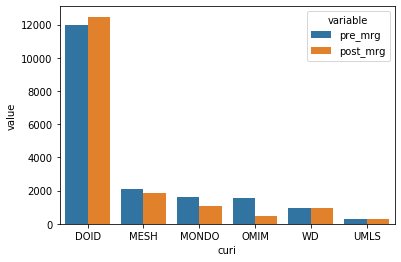

In [101]:
dat = pd.concat([vc1.rename('pre_mrg'), vc2.rename('post_mrg')], axis=1, sort=False).reset_index().rename(columns={'index': 'curi'})

dat_mlt = dat.melt(id_vars = ['curi'], value_vars=['pre_mrg', 'post_mrg'])

sns.barplot(data=dat_mlt, x='curi', y='value', hue='variable')

In [102]:
nodes_out['name'] = nodes_out['name'].fillna(nodes_out['id'].map(old_id_to_name))

In [103]:
nodes_out.to_csv(out_dir.joinpath('nodes.csv'), index=False)
edges_out.to_csv(out_dir.joinpath('edges.csv'), index=False)

In [104]:
update_pheno

,id,name,label,xrefs,source
300191,HP:0000006,Autosomal dominant inheritance,Phenotype,HP:0000006,NaN
300193,HP:0000026,Male hypogonadism,Phenotype,MESH:D005058,NaN
300195,HP:0000068,Urethral atresia,Phenotype,HP:0000068,NaN
300197,HP:0000085,Horseshoe kidney,Phenotype,HP:0000085|MESH:D000069337,NaN
300198,HP:0000089,Renal hypoplasia,Phenotype,NaN,NaN
...,...,...,...,...,...
794385,MESH:D052439,lipid metabolism disorder,Phenotype,MESH:D052439,NaN
794404,MESH:D055623,actinic keratosis,Phenotype,MESH:D055623,NaN
794420,MESH:D057774,post-exercise hypotension,Phenotype,MESH:D057774,NaN
794437,MESH:D065306,corneal damage,Phenotype,MESH:D065306,NaN
